In [1]:
# Make sure to install the requirements with pip install -r requirements.txt
import os
from matplotlib import pyplot as plt
import numpy as np
import torch
import yaml
from argparse import Namespace
from tqdm.notebook import tqdm
from lib.model import get_model_and_optim
from lib.data import prepare_nuclear_data
from lib.utils import preds_targets_zn, PlottingContext, IO, get_rms, get_rms_no_outliers

# Download required files from Zenodo
wget -nc https://zenodo.org/record/8403220/files/nuclr_files.tar

tar -xvf nuclr_files.tar

rm nuclr_files.tar

Now you should have three folders: `checkpoints/`, `data/` and `plots`. 

In [2]:
# !wget -nc https://zenodo.org/record/8403220/files/nuclr_files.tar
# !tar -xvf nuclr_files.tar
# !rm nuclr_files.tar

# Load data and config

In [3]:
# load args from disk
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with open("checkpoints/args.yaml", "r") as f:
    args = yaml.load(f, Loader=yaml.FullLoader)
    args["TARGETS_REGRESSION"] = {
        "binding": 1,
        # "binding_semf": 1,
        # "z": 1,
        # "n": 1,
        # "radius": 1,
        # "qa": 1,
        # "qbm": 1,
        # "qbm_n": 1,
        # "qec": 1,
        # "sn": 1,
        # "sp": 1,
    }

args["DEV"] = device
args = Namespace(**args)
print("Loaded args:", args, "\n")

data = prepare_nuclear_data(args)
print("Loaded Data:", data._fields, data.output_map, "\n")
# fix train_mask for ablation purposes
def fix_mask(data, all_same=True):
    """all_same makes every task have the same mask, otherwise each task has it's own mask given by the order of the task"""
    gen = torch.Generator().manual_seed(42)
    if all_same:
        new_train_mask = torch.rand(data.train_mask.shape[0]//len(data.output_map), generator=gen) < 1
        new_train_mask = new_train_mask.repeat_interleave(len(data.output_map))
    else:
        new_train_mask = [torch.rand(data.train_mask.shape[0]//len(data.output_map), generator=gen) < 0.8 for _ in range(len(data.output_map))]
        new_train_mask = torch.cat(new_train_mask)
    new_train_mask[0] = False # HACK
    new_train_mask = new_train_mask.to(device)
    data = data._replace(train_mask=new_train_mask)
    new_val_mask = ~new_train_mask
    data = data._replace(val_mask=new_val_mask)
    return data

data = fix_mask(data, all_same=True)

Loaded args: Namespace(BATCH_SIZE=1024, CKPT_FREQ=10, CLIP_GRAD=0.001, DEPTH=2, DEV=device(type='cuda'), EPOCHS=50000, HIDDEN_DIM=2048, HOLDOUT='false', LIPSCHITZ='false', LOG_FREQ=1, LR=0.0001, MODEL='baseline', READOUT='identity', ROOT='/work/submit/kitouni/ai-nuclear', SCHED='cosine', SEED=0, SIGMOID_READOUT='false', START_FROM='none', TARGETS_CLASSIFICATION={}, TARGETS_REGRESSION={'binding': 1}, TMS='remove', TRAIN_FRAC=0.9, WANDB=False, WD=0.01, basedir='/work/submit/kitouni/ai-nuclear/FULL/model_baseline/wd_0.01/lr_0.0001/epochs_50000/trainfrac_0.9/hiddendim_2048/depth_2/seed_0/batchsize_1024/targetsclassification_None/targetsregression_binding_semf:1-z:1-n:1-radius:1-qa:1-qbm:1-qbm_n:1-qec:1-sn:1-sp:1/sched_cosine/lipschitz_false') 

Loaded Data: ('X', 'y', 'vocab_size', 'output_map', 'regression_transformer', 'train_mask', 'val_mask') OrderedDict([('binding', 1)]) 



In [4]:
# setup training data
X_train = data.X[data.train_mask]
y_train = data.y[data.train_mask]
non_nan_targets = ~torch.isnan(y_train.view(-1))
X_train = X_train[non_nan_targets]
y_train = y_train[non_nan_targets]

def quick_eval(model, task="binding", verbose=True, train=False):
    """helper to get the rms for the franken model"""
    preds, targets, zn = preds_targets_zn(data, model, task, train=train)
    rms = get_rms(preds, targets, zn, scale_by_A=True)
    rms_clip = get_rms_no_outliers(preds, targets, zn, scale_by_A=True)
    if verbose:
        print(f"RMS for franken model: {rms:.2f}")
        print(f"RMS for franken model (clipped): {rms_clip:.2f}")
    return rms, rms_clip

torch.manual_seed(1)
new_model, optim_model = get_model_and_optim(data, args)

# Training

In [6]:
# train the new model
epochs = 10_000
for epoch in (pbar:=tqdm(range(epochs))):
    optim_model.zero_grad()
    preds = new_model(X_train)
    preds = preds.gather(1, X_train[:, 2].long().view(-1, 1))
    loss = torch.nn.functional.mse_loss(preds, y_train)
    loss.backward()
    optim_model.step()
    if epoch % (epochs//10) == 0:
        print(f"Epoch {epoch}: {loss.item():.2f}")
        train_rms = quick_eval(new_model, "binding", verbose=False, train=True)
        # val_rms = quick_eval(new_model, "binding", verbose=False, train=False)
        print(f"Train RMS: {train_rms[0]:.2f} ({train_rms[1]:.2f})", end=" ")
        # print(f"Val RMS: {val_rms[0]:.2f} ({val_rms[1]:.2f})")
    pbar.set_description(f"Epoch {epoch}: {loss.item():.2e}")

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 0: 0.38
Train RMS: 225890.33 (225203.23) Epoch 1000: 0.00
Train RMS: 8463.38 (8057.91) Epoch 2000: 0.00
Train RMS: 7794.88 (7438.00) Epoch 3000: 0.00
Train RMS: 7538.65 (7191.14) Epoch 4000: 0.00
Train RMS: 7280.38 (6930.17) Epoch 5000: 0.00
Train RMS: 3834.47 (3527.29) Epoch 6000: 0.00
Train RMS: 1374.47 (1191.10) Epoch 7000: 0.00
Train RMS: 645.95 (540.07) Epoch 8000: 0.00
Train RMS: 310.26 (261.43) Epoch 9000: 0.00
Train RMS: 150.18 (133.26) 

# PCA Experiments

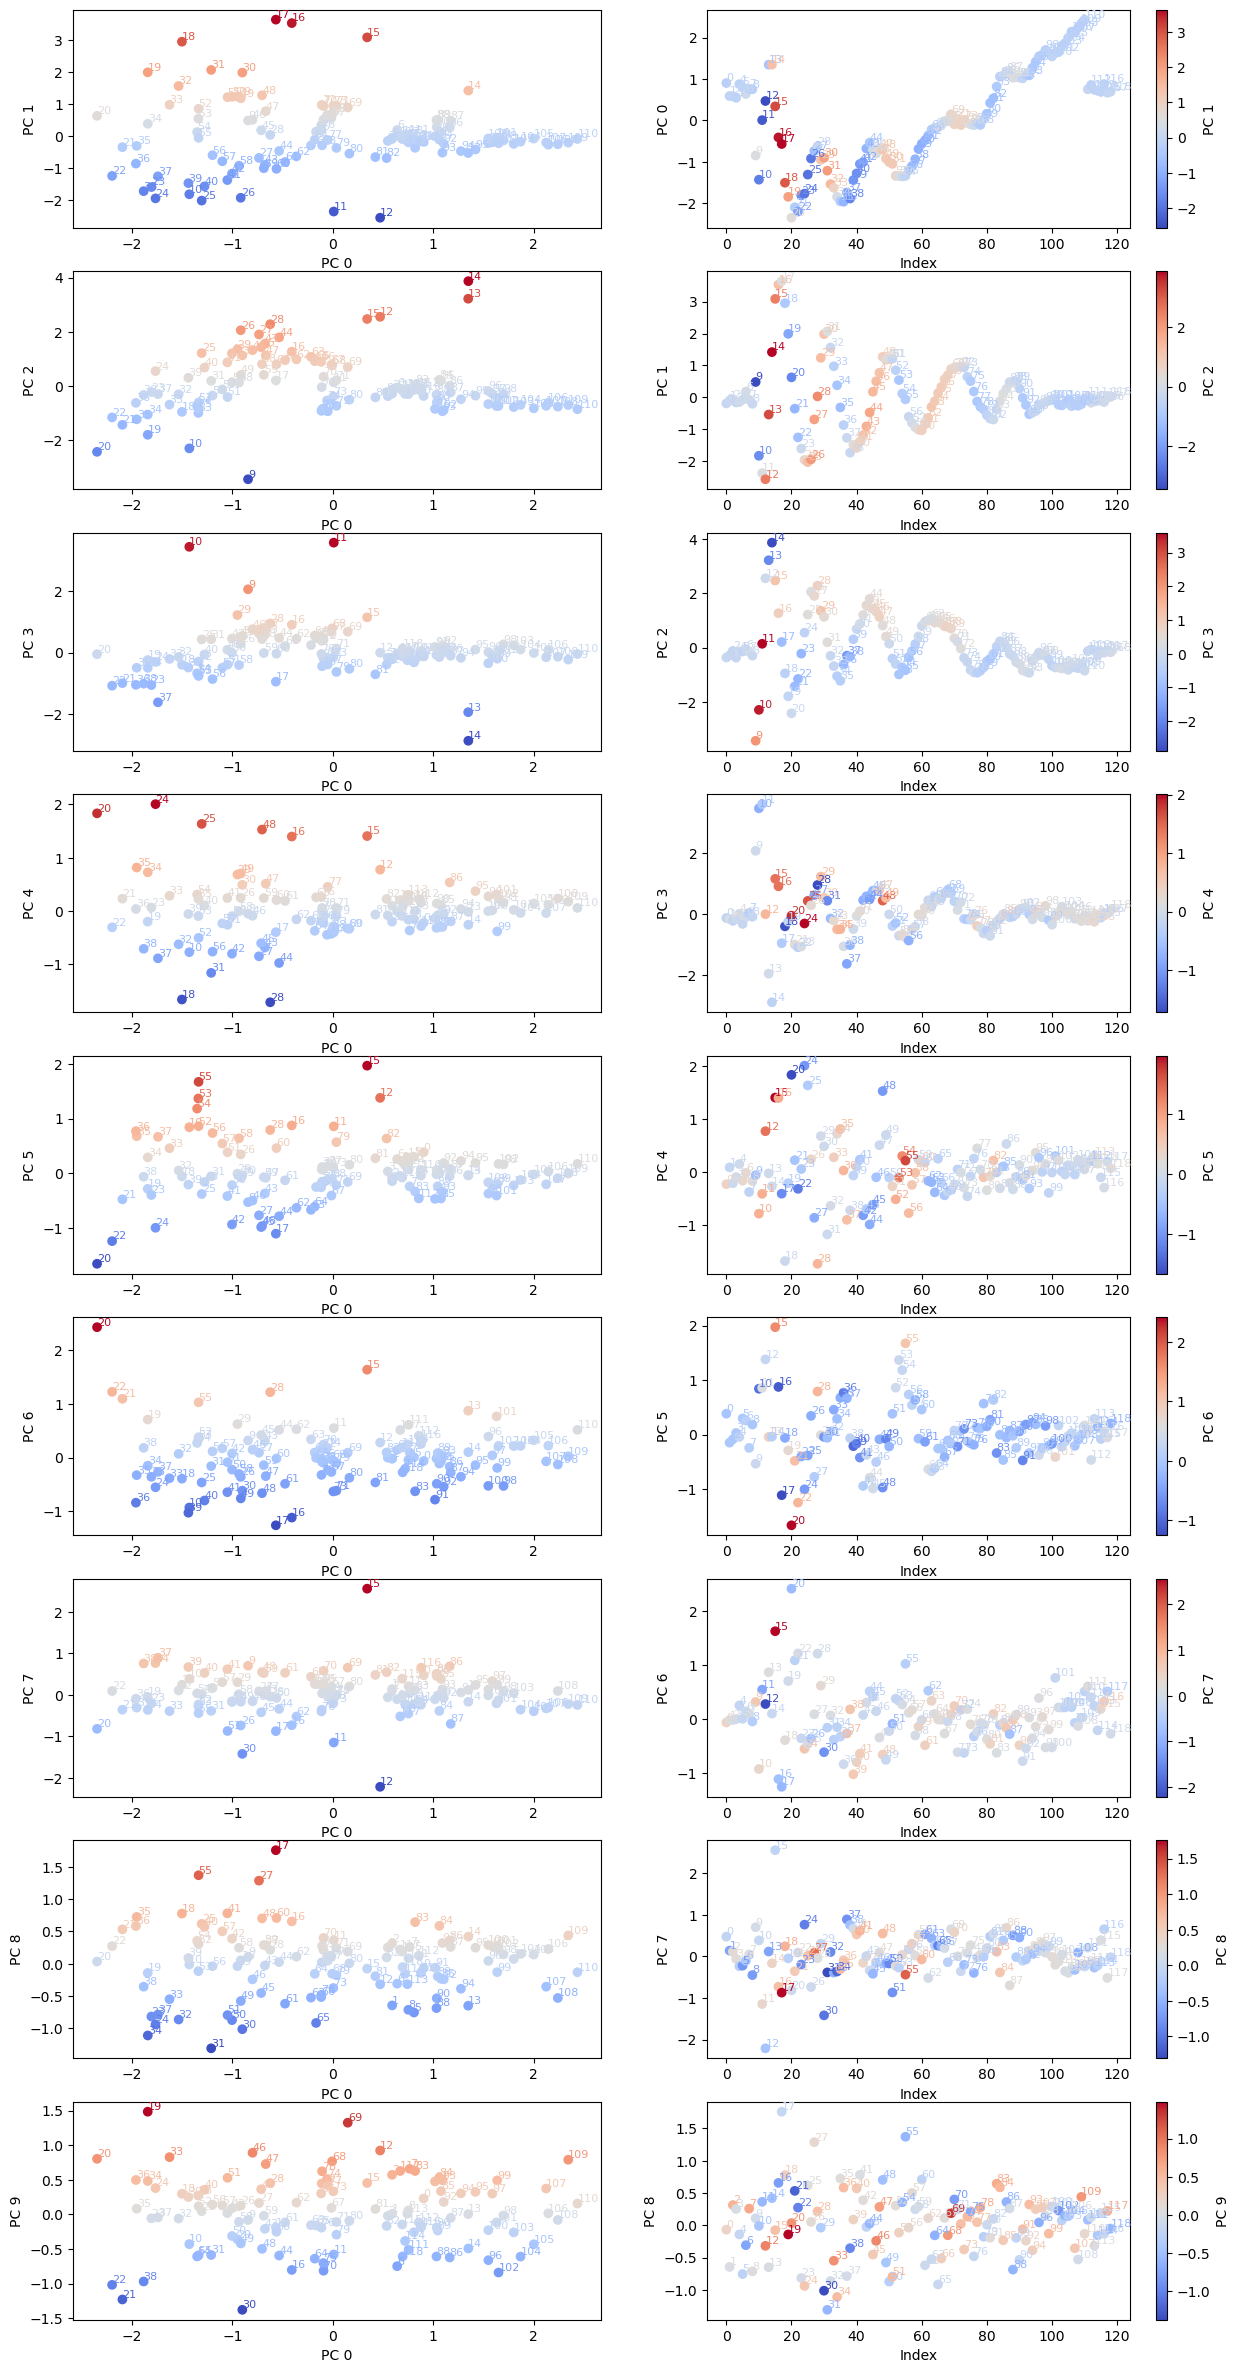

In [5]:
location = f"{IO.get_root()}/binding_2/"
args = IO.load_args(f"{location}/args.yaml")
data = prepare_nuclear_data(args)
data = fix_mask(data, all_same=True)
new_model = get_model_and_optim(data, args)[0]
new_model.load_state_dict(torch.load(f"{location}/ckpts/model-45000.pt"))
# let's take a look at our embeddings
embed = new_model.emb[0].detach().cpu().numpy()
PlottingContext.plot_embedding(embed, num_components=10)
plt.show()

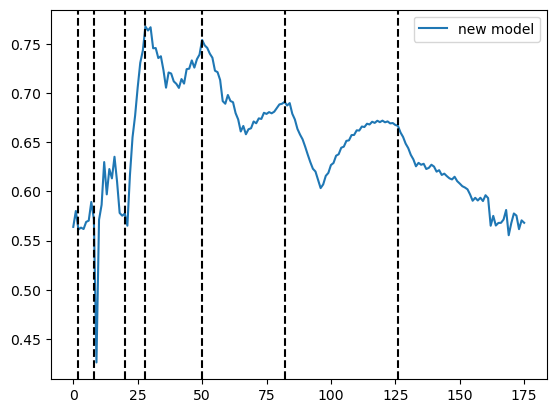

In [16]:
fixed_X = torch.arange(0, 176).view(-1, 1).to(device).repeat_interleave(3, dim=1)
fixed_X[:, 2] = 0
fixed_X[:, 0] = 82
magic_numbers = [2, 8, 20, 28, 50, 82, 126]
# plot the new model
with torch.no_grad():
    new_model.eval()
    preds = new_model(fixed_X)[:, 0]
    preds = preds.cpu().numpy()
    plt.plot(fixed_X[:, 1].cpu().numpy(), preds, label="new model")
    for magic_number in magic_numbers:
        plt.axvline(magic_number, color="black", linestyle="--")
    plt.legend()
    plt.show()

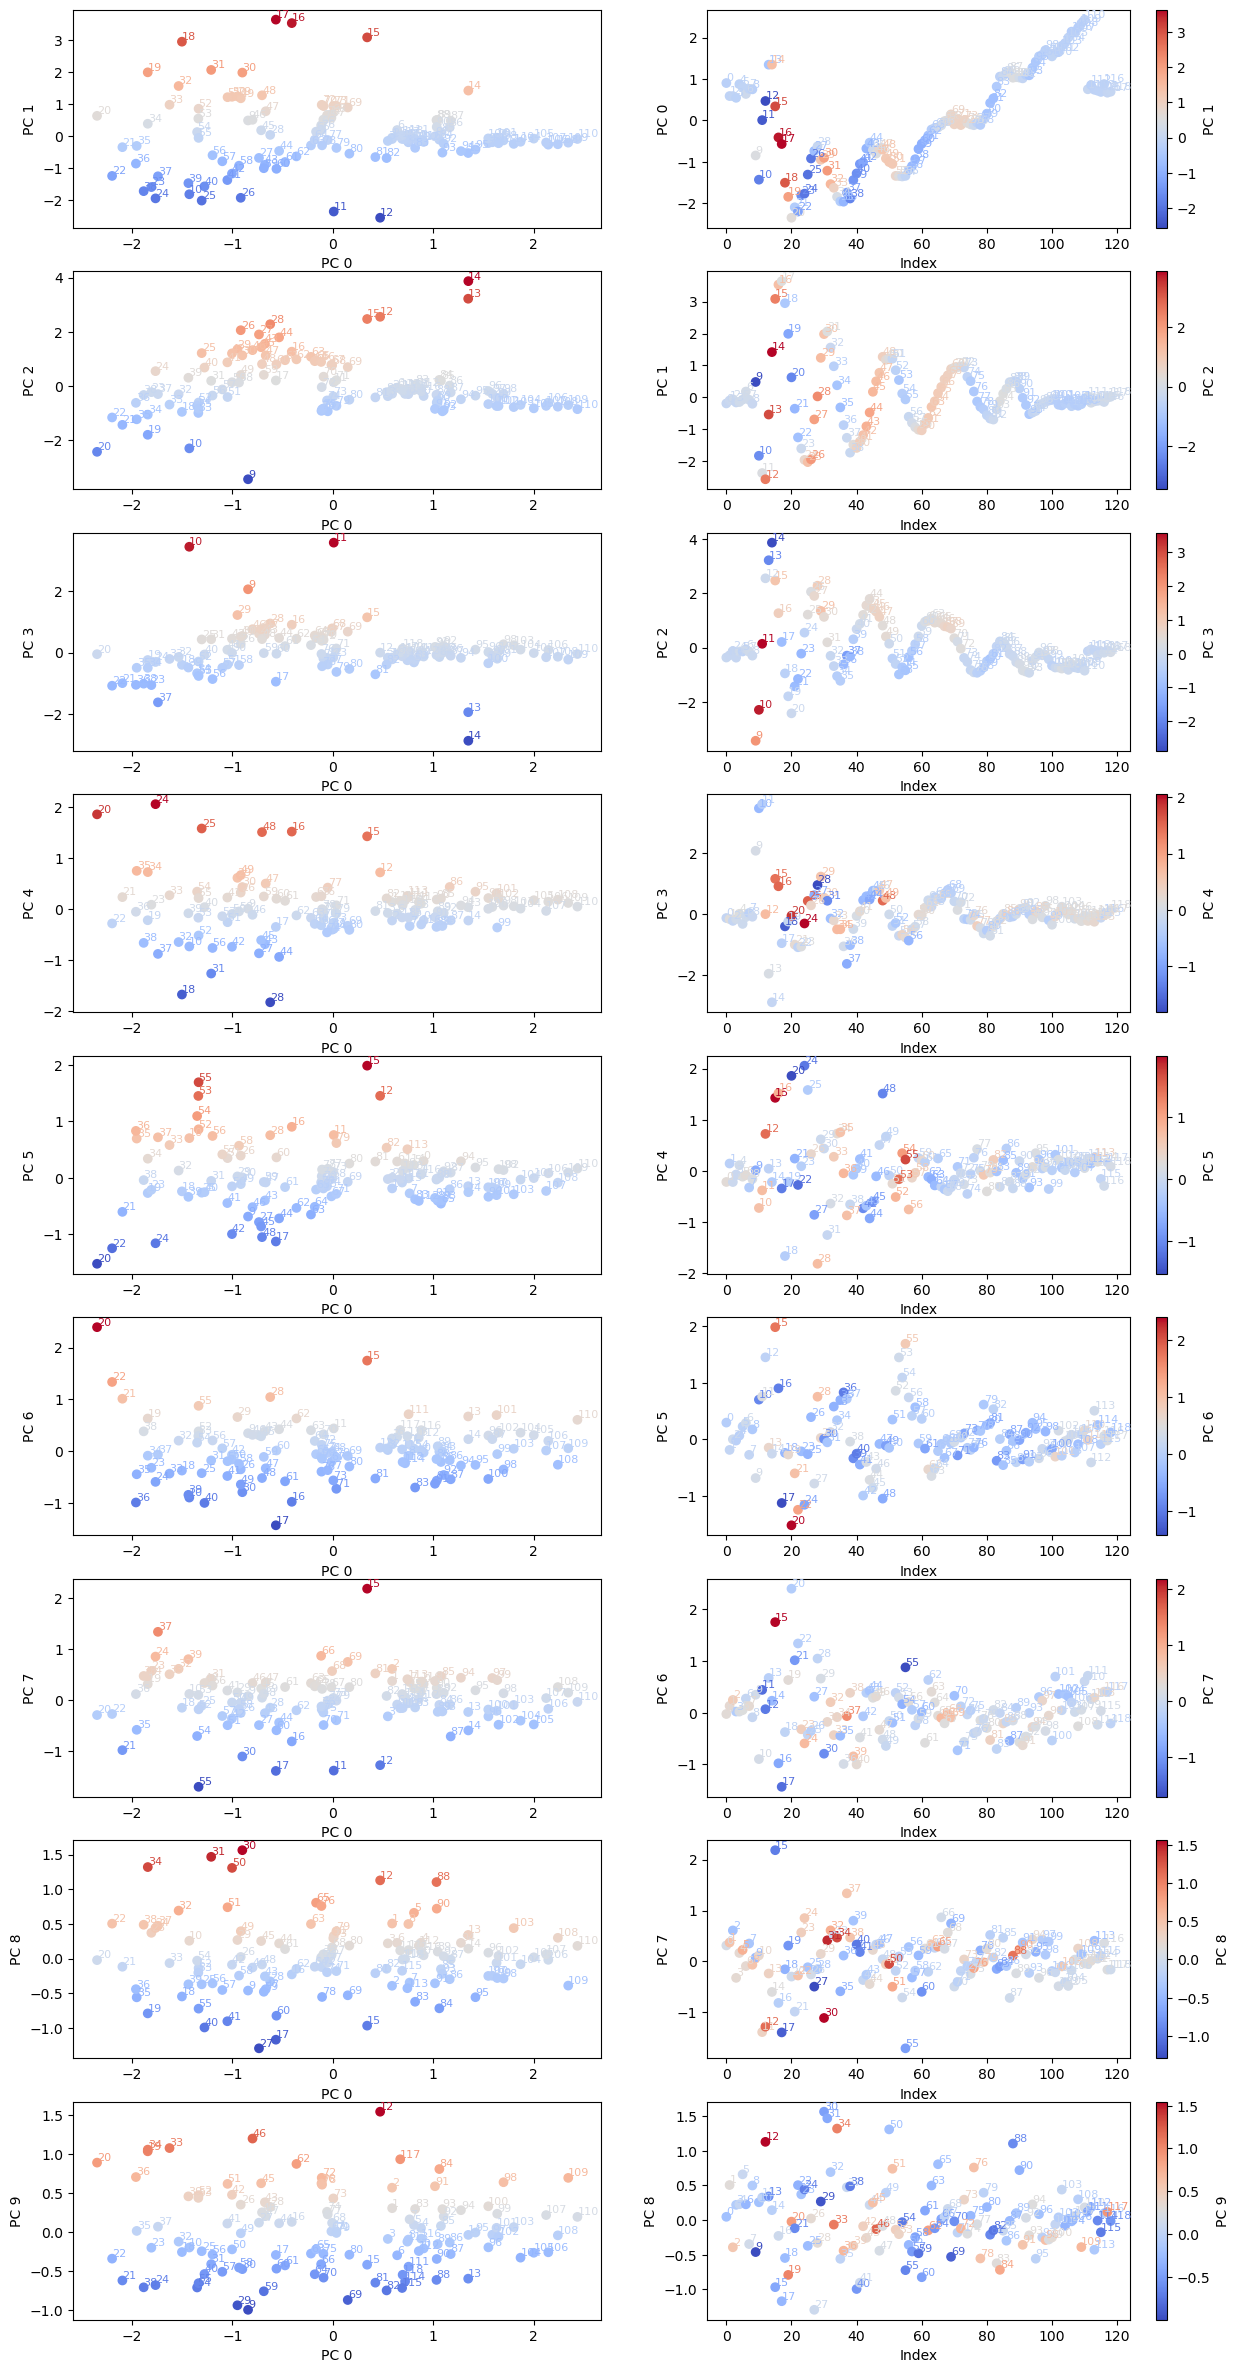

In [65]:
location = "results/binding_2/"
args = IO.load_args(f"{location}/args.yaml")
data = prepare_nuclear_data(args)
data = fix_mask(data, all_same=True)
new_model = get_model_and_optim(data, args)[0]
new_model.load_state_dict(torch.load(f"{location}/ckpts/model-45000.pt"))
# let's take a look at our embeddings
embed = new_model.emb[0].detach().cpu().numpy()
PlottingContext.plot_embedding(embed, num_components=10)
plt.show()

In [66]:
X_train = data.X[~torch.isnan(data.y).view(-1)]
y_train = data.y[~torch.isnan(data.y).view(-1)]

X_train, y_train = X_train[X_train[:, 2] == 0],  y_train[X_train[:, 2] == 0]

# Save the last layer activations
acts = torch.zeros(len(X_train), 2048, device=device)
# save the activations fed into the readout layer
hook = new_model.readout.register_forward_pre_hook(lambda m, i: acts.copy_(i[0].detach()))
new_model(X_train)
hook.remove()

def inverse_transform(vector, index):
    """inverse transform the vector to the original scale"""
    scale = data.regression_transformer.data_max_[index] - data.regression_transformer.data_min_[index]
    min_ = data.regression_transformer.data_min_[index]
    vector = vector * scale + min_
    return vector

# Ensure that the RMS is the same as the franken model
def get_preds_from_last_acts(acts):
    preds = new_model.readout(acts) #- new_model.readout.bias
    preds = preds.detach().cpu().numpy()
    preds = data.regression_transformer.inverse_transform(preds)
    # preds = preds / data.regression_transformer.scale_ # + data.regression_transformer.min_
    return preds[:, 0]

def get_rms_from_last_acts(acts):
    preds = get_preds_from_last_acts(acts)
    targets = y_train.detach().cpu().numpy().reshape(-1)
    targets = inverse_transform(targets, 0)
    zn = X_train[:, :2].detach().cpu().numpy()
    rms = get_rms(preds, targets, zn, scale_by_A=True)
    return rms
print(f"RMS recomputed: {get_rms_from_last_acts(acts):.2f}")
quick_eval(new_model, train=True); print(end="")

RMS recomputed: 57.98
RMS for franken model: 57.99
RMS for franken model (clipped): 57.57


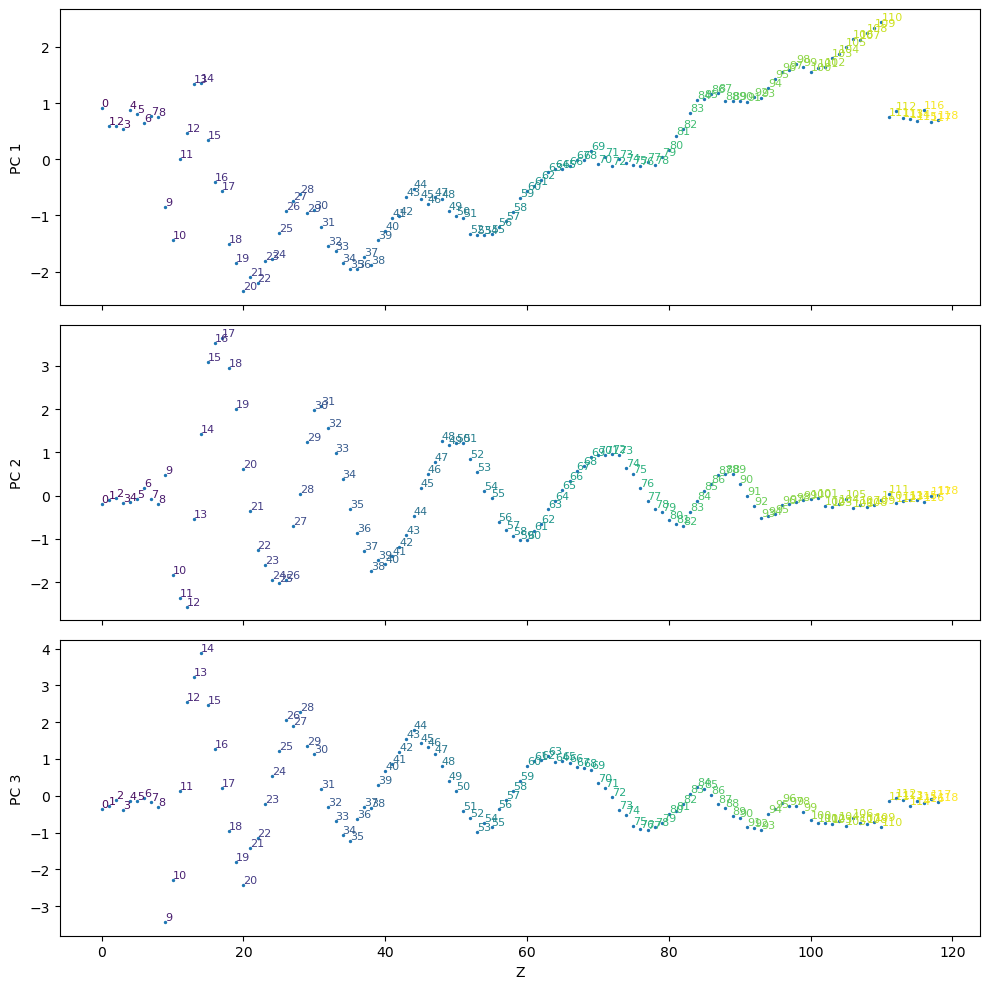

In [ ]:
# let's take a look at our embeddings
embed = new_model.emb[0].detach().cpu().numpy()

pca = PCA(n_components=(n_components:=3))
embed = pca.fit_transform(embed)
colors = plt.cm.viridis(np.linspace(0, 1, len(embed)))

fig, axes = plt.subplots(n_components, 1, figsize=(10, 10), sharex=True)
axes = axes.flatten()
for i in range(0, n_components):
    ax = axes[i]
    x, y = np.arange(len(embed)), embed[:, i]
    ax.scatter(x, y, s=2)
    PlottingContext.scatter_text(np.arange(len(embed)), x, y, colors=colors, ax=ax, fontsize=8)
    ax.set_ylabel(f"PC {i+1}")

ax.set_xlabel("N")
fig.tight_layout()
plt.show()


AttributeError: 'PLSRegression' object has no attribute 'explained_variance_ratio_'

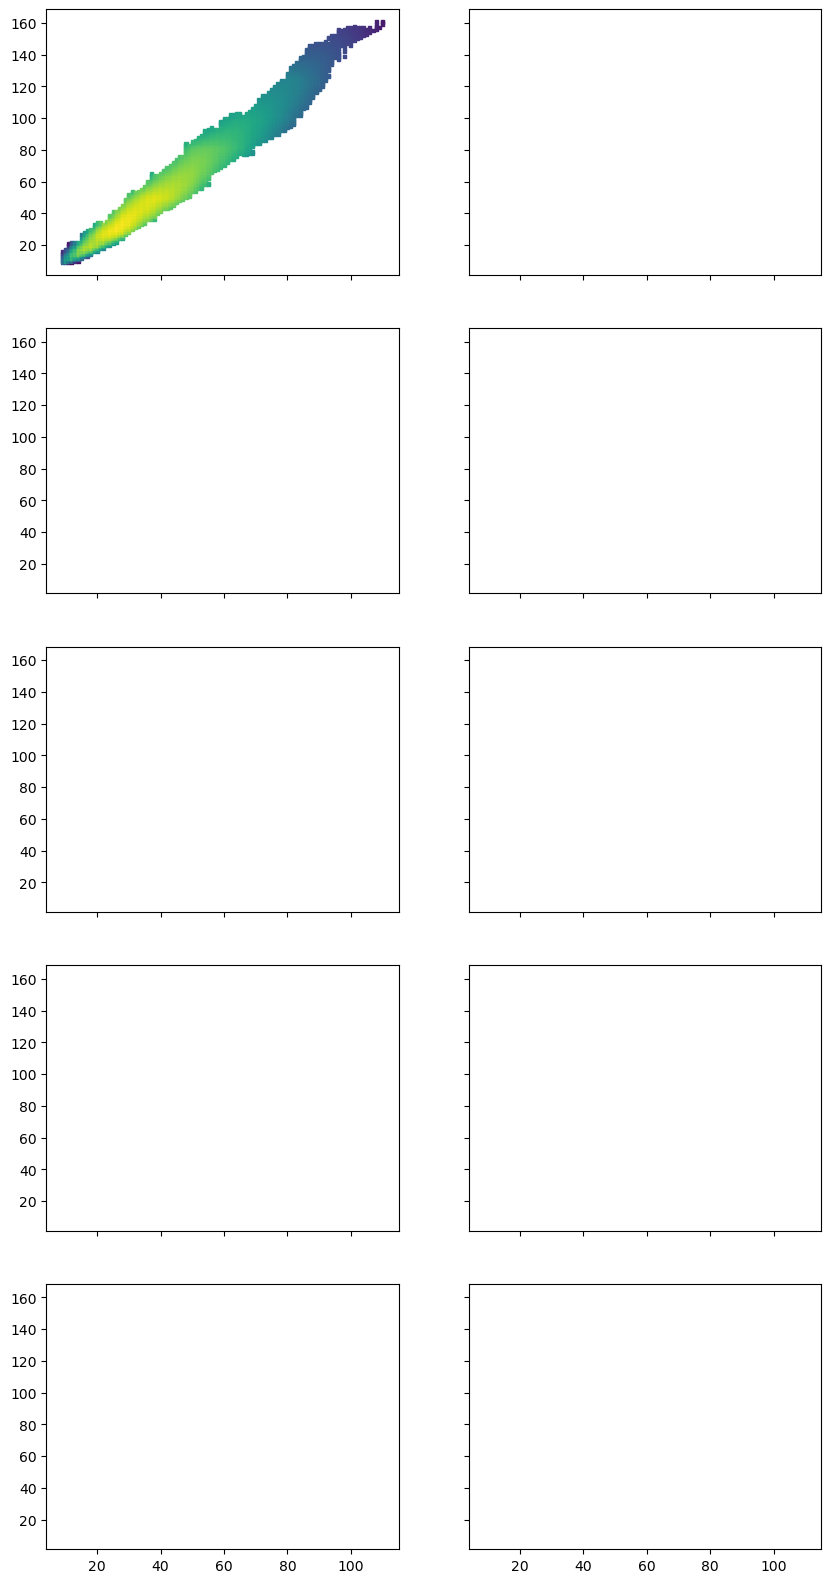

In [67]:
# last layer PCs
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression, CCA, PLSCanonical
import matplotlib.pyplot as plt


# pca = PCA(n_components=100)
pca = PLSRegression(n_components=10)
acts_pca = pca.fit_transform(acts.cpu().numpy(), y_train.detach().cpu().numpy().flatten())[0]
# let's visualize all the PCs as a function of input
num_plots = min(acts_pca.shape[1], 10)
fig, axes = plt.subplots(max(num_plots//2, 1), 2, figsize=(10, 2 * num_plots), sharex=True, sharey=True)
axes = axes.flatten()
Z, N = X_train[:, 0].detach().cpu().numpy(), X_train[:, 1].detach().cpu().numpy()
scale = data.regression_transformer.data_max_ - data.regression_transformer.data_min_
min_ = data.regression_transformer.data_min_

features = []
for i in range(num_plots):
    # get rms for the current PC
    acts_pca_ = acts_pca.copy()
    acts_pca_[:, i+1:] = 0
    acts_pca_cumulative = pca.inverse_transform(acts_pca_)
    acts_pca_cumulative = torch.tensor(acts_pca_cumulative, device=device, dtype=torch.float32)
    rms = get_rms_from_last_acts(acts_pca_cumulative)
    # plot
    ax = axes.flatten()[i]
    acts_pca_[:, :i] = 0
    acts_pca_singular = pca.inverse_transform(acts_pca_)
    acts_pca_singular = torch.tensor(acts_pca_singular, device=device, dtype=torch.float32)
    color = new_model.readout(acts_pca_singular).detach().cpu().numpy()
    color = (color * scale + min_)[:, 0]
    # color = get_preds_from_last_acts(acts_pca_singular)
    features.append(color)
    sc = ax.scatter(Z, N, c=color, s=5, marker='s')
    ax.set_title(f"PC {i} (exp. var.: {pca.explained_variance_ratio_[i]:.3f}, Cumulative RMS: {rms:.0f})")
    fig.colorbar(sc, ax=ax)
fig.tight_layout()
plt.show()
features = np.array(features)

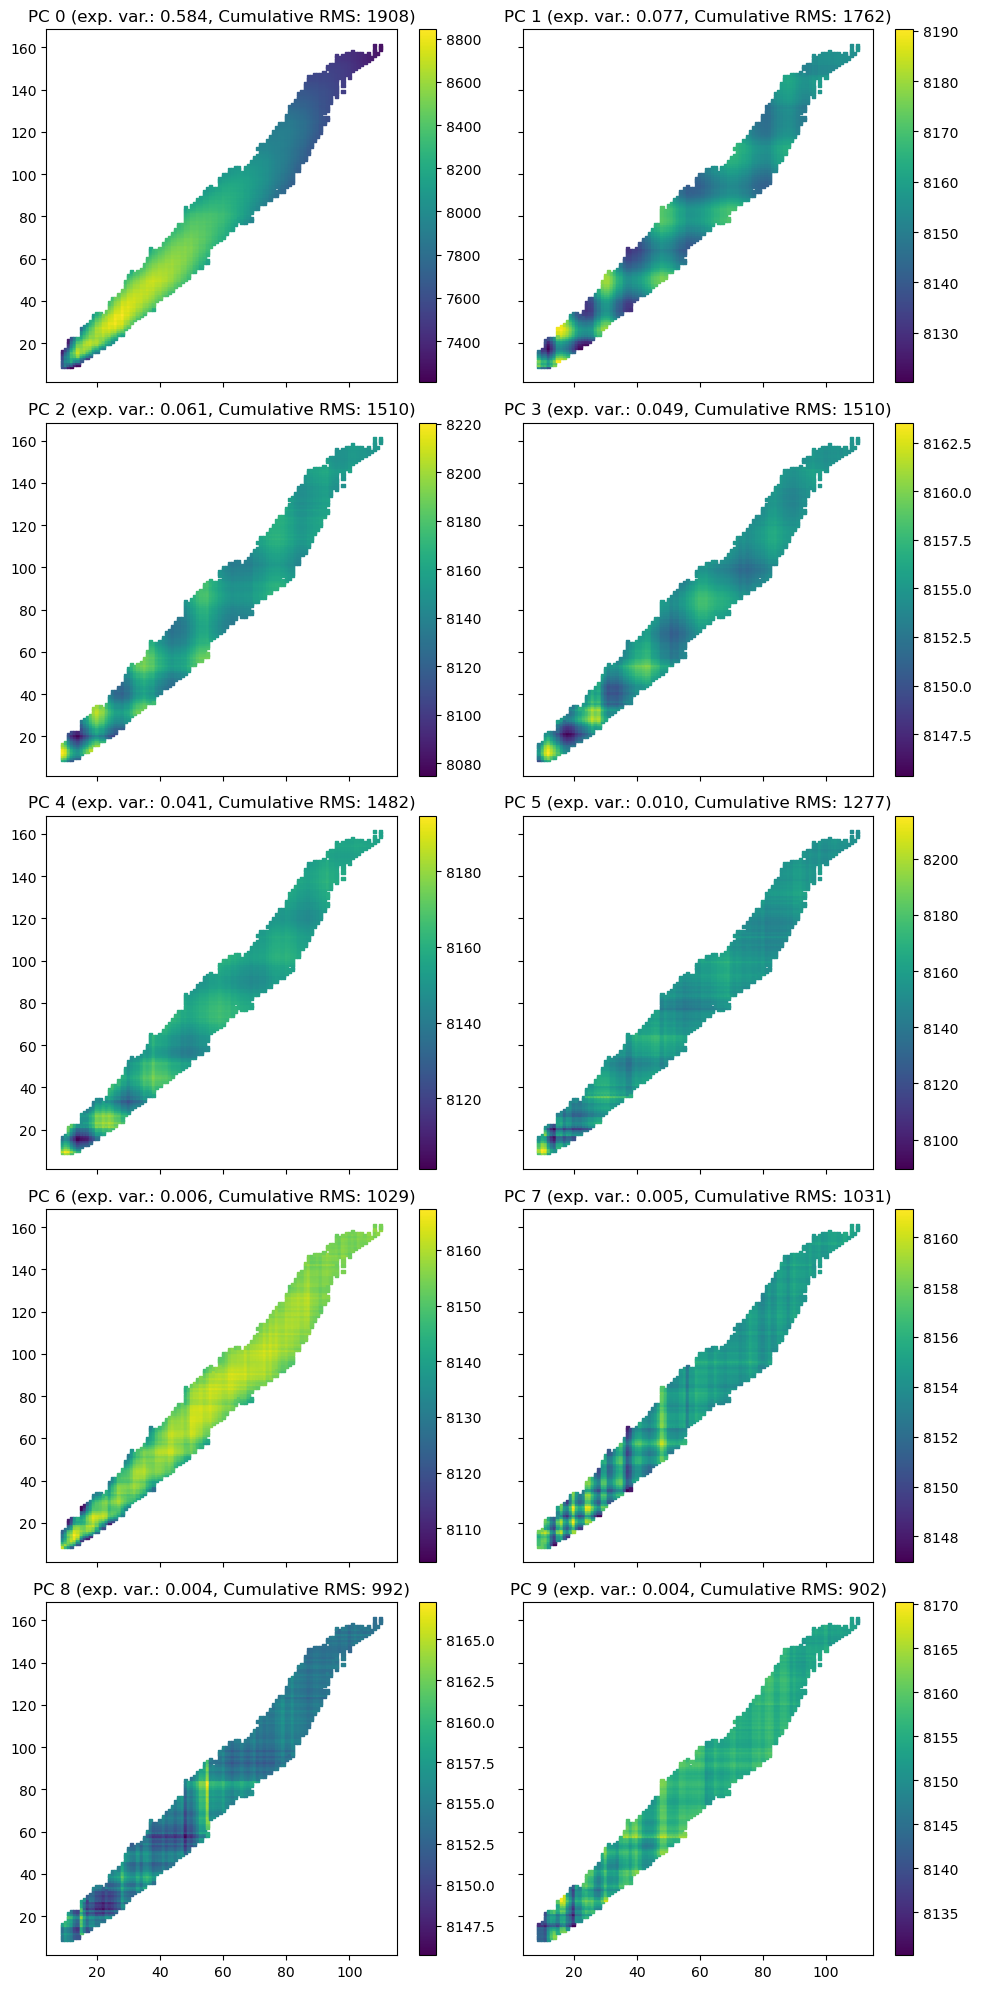

In [68]:
# last layer PCs
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=100)
acts_pca = pca.fit_transform(acts.cpu().numpy())
# let's visualize all the PCs as a function of input
num_plots = min(acts_pca.shape[1], 10)
fig, axes = plt.subplots(num_plots//2, 2, figsize=(10, 2 * num_plots), sharex=True, sharey=True)
axes = axes.flatten()
Z, N = X_train[:, 0].detach().cpu().numpy(), X_train[:, 1].detach().cpu().numpy()
scale = data.regression_transformer.data_max_ - data.regression_transformer.data_min_
min_ = data.regression_transformer.data_min_

features = []
for i in range(num_plots):
    # get rms for the current PC
    acts_pca_ = acts_pca.copy()
    acts_pca_[:, i+1:] = 0
    acts_pca_cumulative = pca.inverse_transform(acts_pca_)
    acts_pca_cumulative = torch.tensor(acts_pca_cumulative, device=device)
    rms = get_rms_from_last_acts(acts_pca_cumulative)
    # plot
    ax = axes.flatten()[i]
    acts_pca_[:, :i] = 0
    acts_pca_singular = pca.inverse_transform(acts_pca_)
    acts_pca_singular = torch.tensor(acts_pca_singular, device=device)
    color = new_model.readout(acts_pca_singular).detach().cpu().numpy()
    color = (color * scale + min_)[:, 0]
    # color = get_preds_from_last_acts(acts_pca_singular)
    features.append(color)
    sc = ax.scatter(Z, N, c=color, s=5, marker='s')
    ax.set_title(f"PC {i} (exp. var.: {pca.explained_variance_ratio_[i]:.3f}, Cumulative RMS: {rms:.0f})")
    fig.colorbar(sc, ax=ax)
fig.tight_layout()
plt.show()
features = np.array(features)

In [69]:
pca_save_dir = f"{location}/last_layer"
os.makedirs(pca_save_dir, exist_ok=True)
np.save(f"{pca_save_dir}/acts.npy", acts.cpu().numpy())
np.save(f"{pca_save_dir}/acts_pca.npy", acts_pca)
np.save(f"{pca_save_dir}/pca_weights.npy", pca.components_)
np.save(f"{pca_save_dir}/features.npy", features)
np.save(f"{pca_save_dir}/zn.npy", np.array([Z, N]).T)

In [90]:
# pure semf 
from lib.data import semi_empirical_mass_formula

semf = semi_empirical_mass_formula(Z, N)
dot_prod = np.dot(features, semf)
dot_prod /= np.linalg.norm(semf)
dot_prod /= np.linalg.norm(features, axis=1)
np.sqrt(((semf - features)**2).mean(axis=1))

array([252.38838928, 369.33841335, 311.9307634 , 380.80301392,
       380.1308038 , 378.35418225, 379.0896173 , 380.80092542,
       380.79639314, 380.64753182])

[1490.0092839526303, 1233.0855792295226, 1235.5354386934926, 1126.2874556574923, 1072.0374679876993, 1076.7444283314965, 1098.1556160490163, 1097.920822388754, 1098.1723586816577, 1097.7199568998158, 1099.5533516668697, 1008.1253374197129, 987.276053033691, 966.6206138365026, 966.6271431597072, 963.2565228960221, 949.6830835990609, 933.7757454882453, 939.340993485955, 908.8475354313643, 909.458646887698, 891.2828545783053, 905.4147303507426, 890.7726171621058, 892.8223662601025, 870.5601911742688, 858.7156599374325, 848.7754648344669, 849.20031598276, 842.5401919587439, 843.7930208191743, 813.2009772497494, 815.86710021803, 817.4009311768406, 818.8503103499418, 822.9282748158971, 808.9883804639744, 813.6477027009955, 812.8635030023689, 812.4667776639933, 812.7390112753881, 812.708168679982, 812.8412473749197, 813.1003600214391, 812.6691440513163, 803.9282758744622, 803.9499539801819, 783.5497292927033, 786.824202638823, 789.1484437499888, 767.0076632242208, 762.872874916527, 762.913987

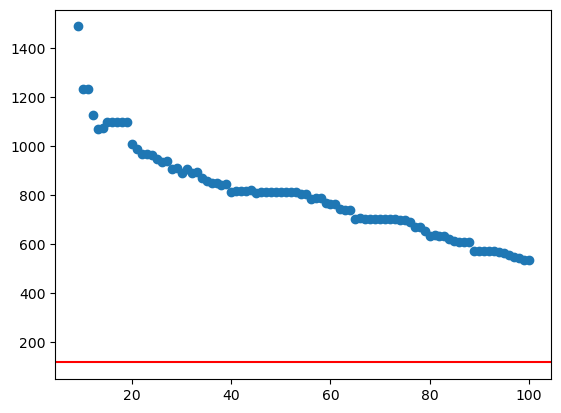

In [91]:
# check the rms based on the PCs
rms_old = get_rms_from_last_acts(acts)
rms_from_pcs = []

pca = PCA(n_components=100)
acts_pca = pca.fit_transform(acts.cpu().numpy())

for i in (pcs:=range(9, acts_pca.shape[1]+1)):
    acts_pca_ = acts_pca.copy()
    acts_pca_[:, i:] = 0
    acts_pca_ = pca.inverse_transform(acts_pca_)
    acts_ = torch.tensor(acts_pca_, device=device)
    rms_from_pcs.append(get_rms_from_last_acts(acts_))
print(rms_from_pcs, rms_old)
plt.scatter(pcs, rms_from_pcs)
plt.axhline(rms_old, color="red")

# L1 Sparse Autoencoder Experiment

In [39]:
from lib.model import AutoEncoder

ae = AutoEncoder(2048, 2048 * 10).to(device)

quick_eval(new_model)
acts = torch.zeros(len(X_train), 2048, device=device)
# save the activations fed into the readout layer
hook = new_model.readout.register_forward_pre_hook(lambda m, i: acts.copy_(i[0].detach()))
new_model(X_train)
hook.remove()

RMS for franken model: 7784.99
RMS for franken model (clipped): nan


/work/submit/kitouni/miniconda3/envs/sandbox/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/work/submit/kitouni/miniconda3/envs/sandbox/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
# train the autoencoder
optim = torch.optim.Adam(ae.parameters(), lr=1e-3)
epochs = 1_000
for epoch in (pbar := tqdm(range(epochs))):
    optim.zero_grad()
    preds, features = ae(acts)
    reco = torch.nn.functional.mse_loss(preds, acts)
    loss = reco + 1e-10 * (
        l1 := features.abs().mean()
    )  # L1 regularization on the features
    loss.backward()
    optim.step()
    pbar.set_description(f"Epoch {epoch}: {reco.item():.2e}, {l1.item():.2e}")

  0%|          | 0/10000 [00:00<?, ?it/s]

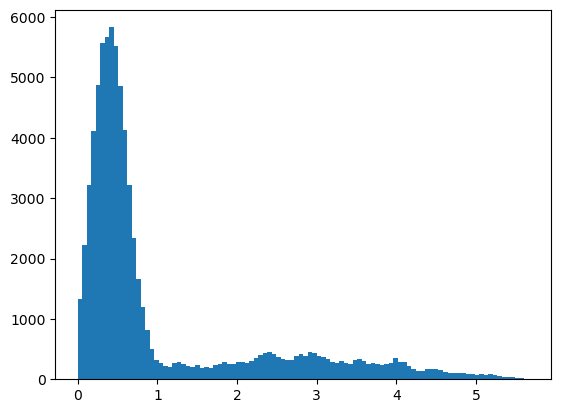

In [8]:
from matplotlib import pyplot as plt
a = features.abs()

plt.hist(a[a>0].cpu().detach().numpy(), bins=100)
plt.show()

In [ ]:
# need to absorb the autoencoder decoder into the last layer of the new_model


# Model Loading and Evaluation

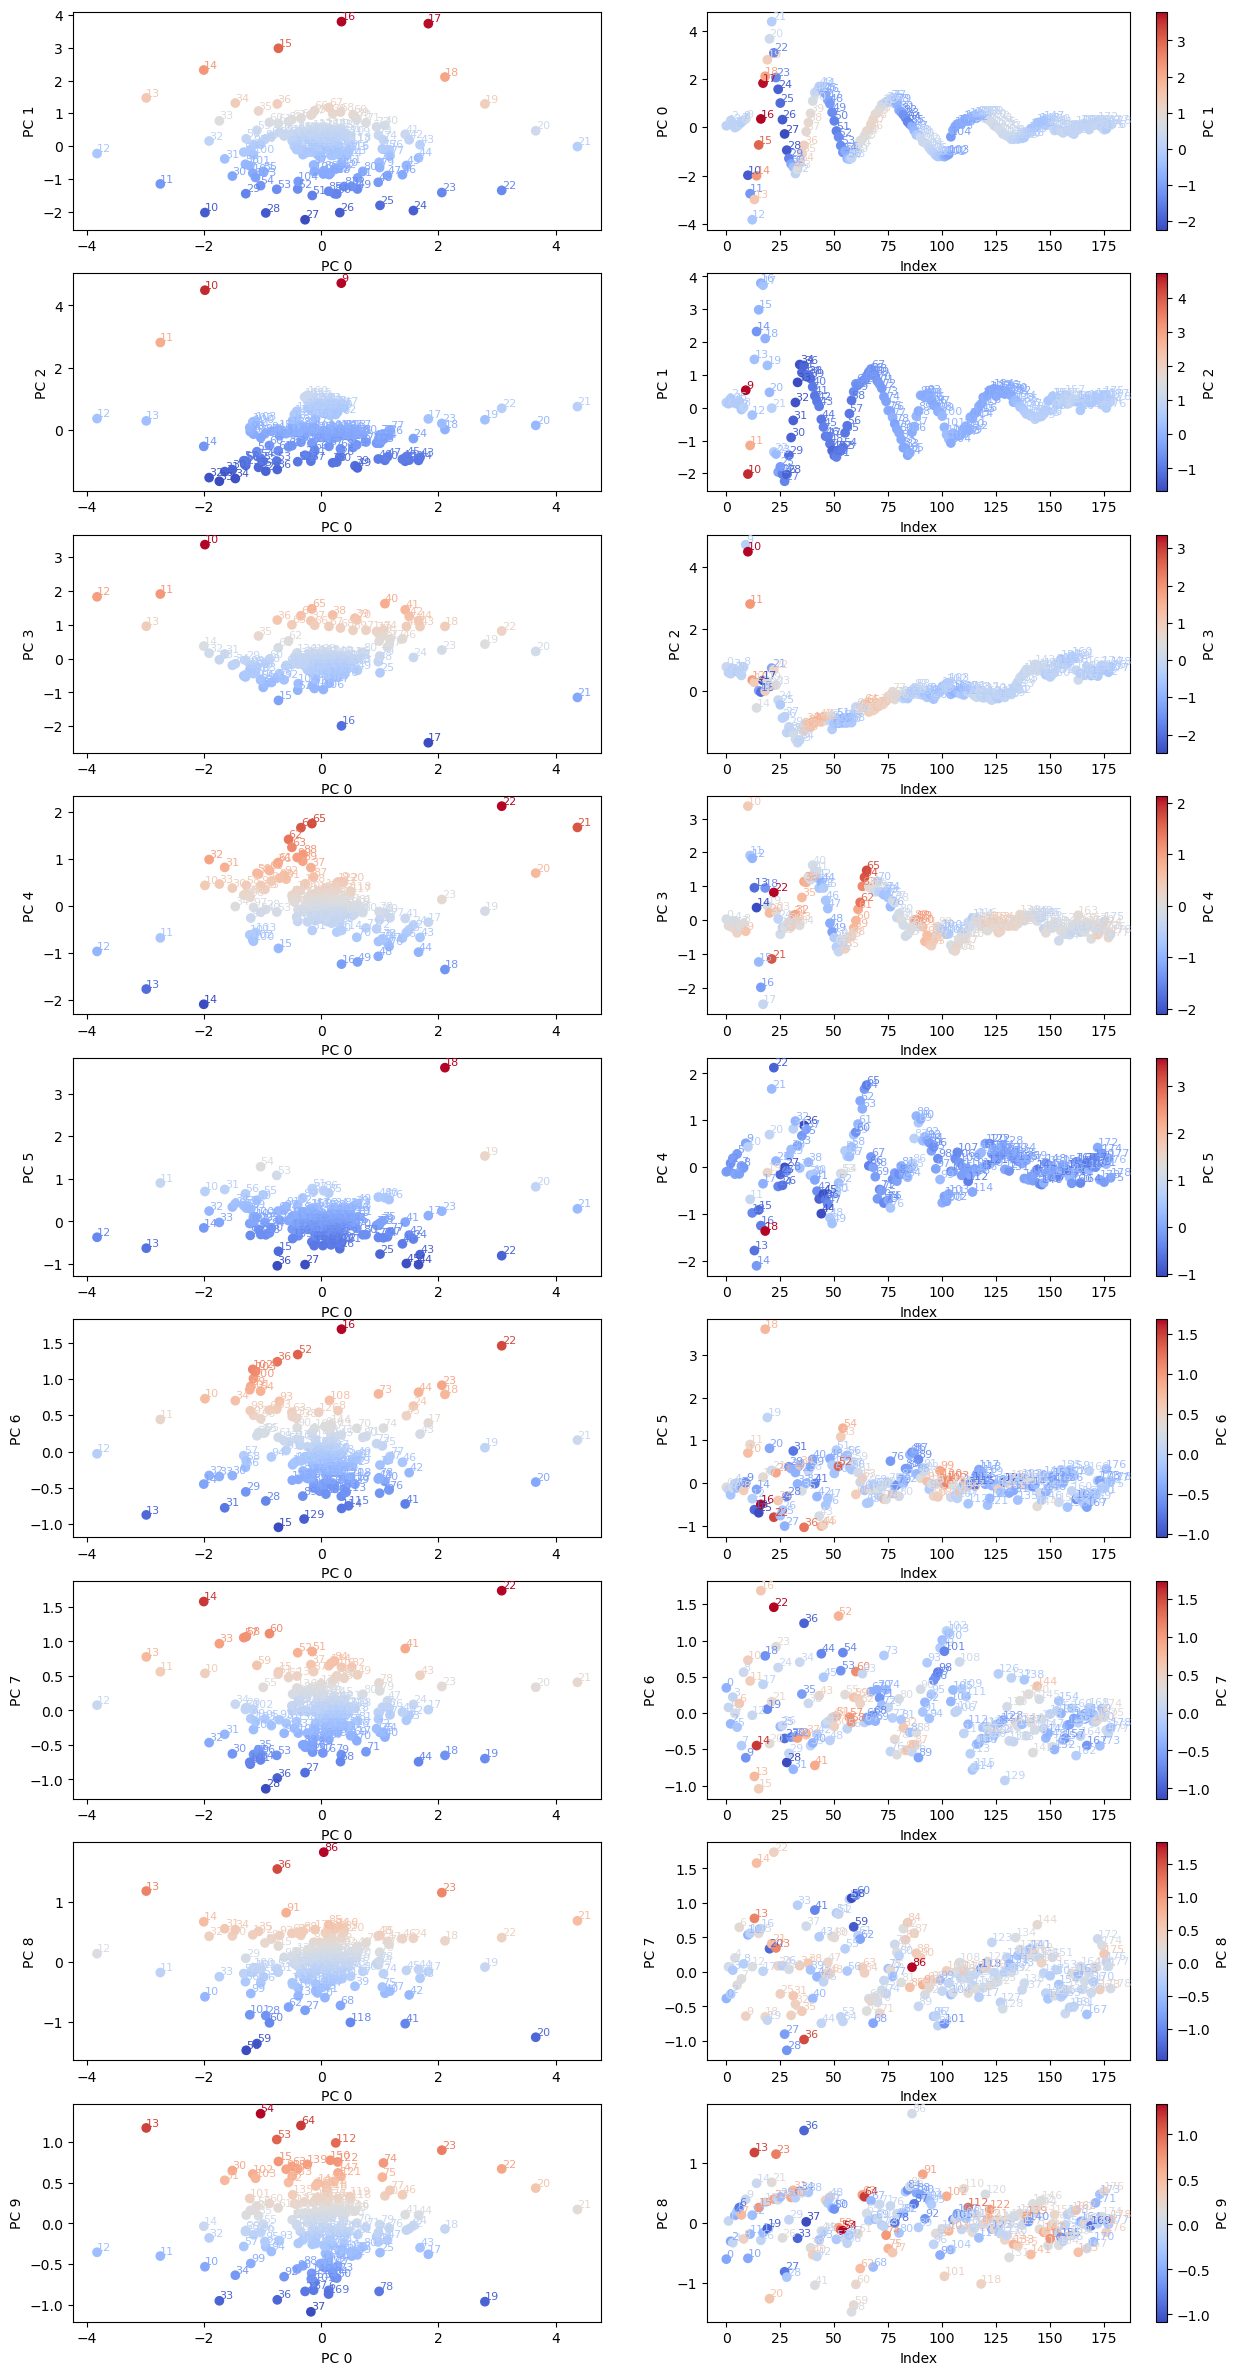

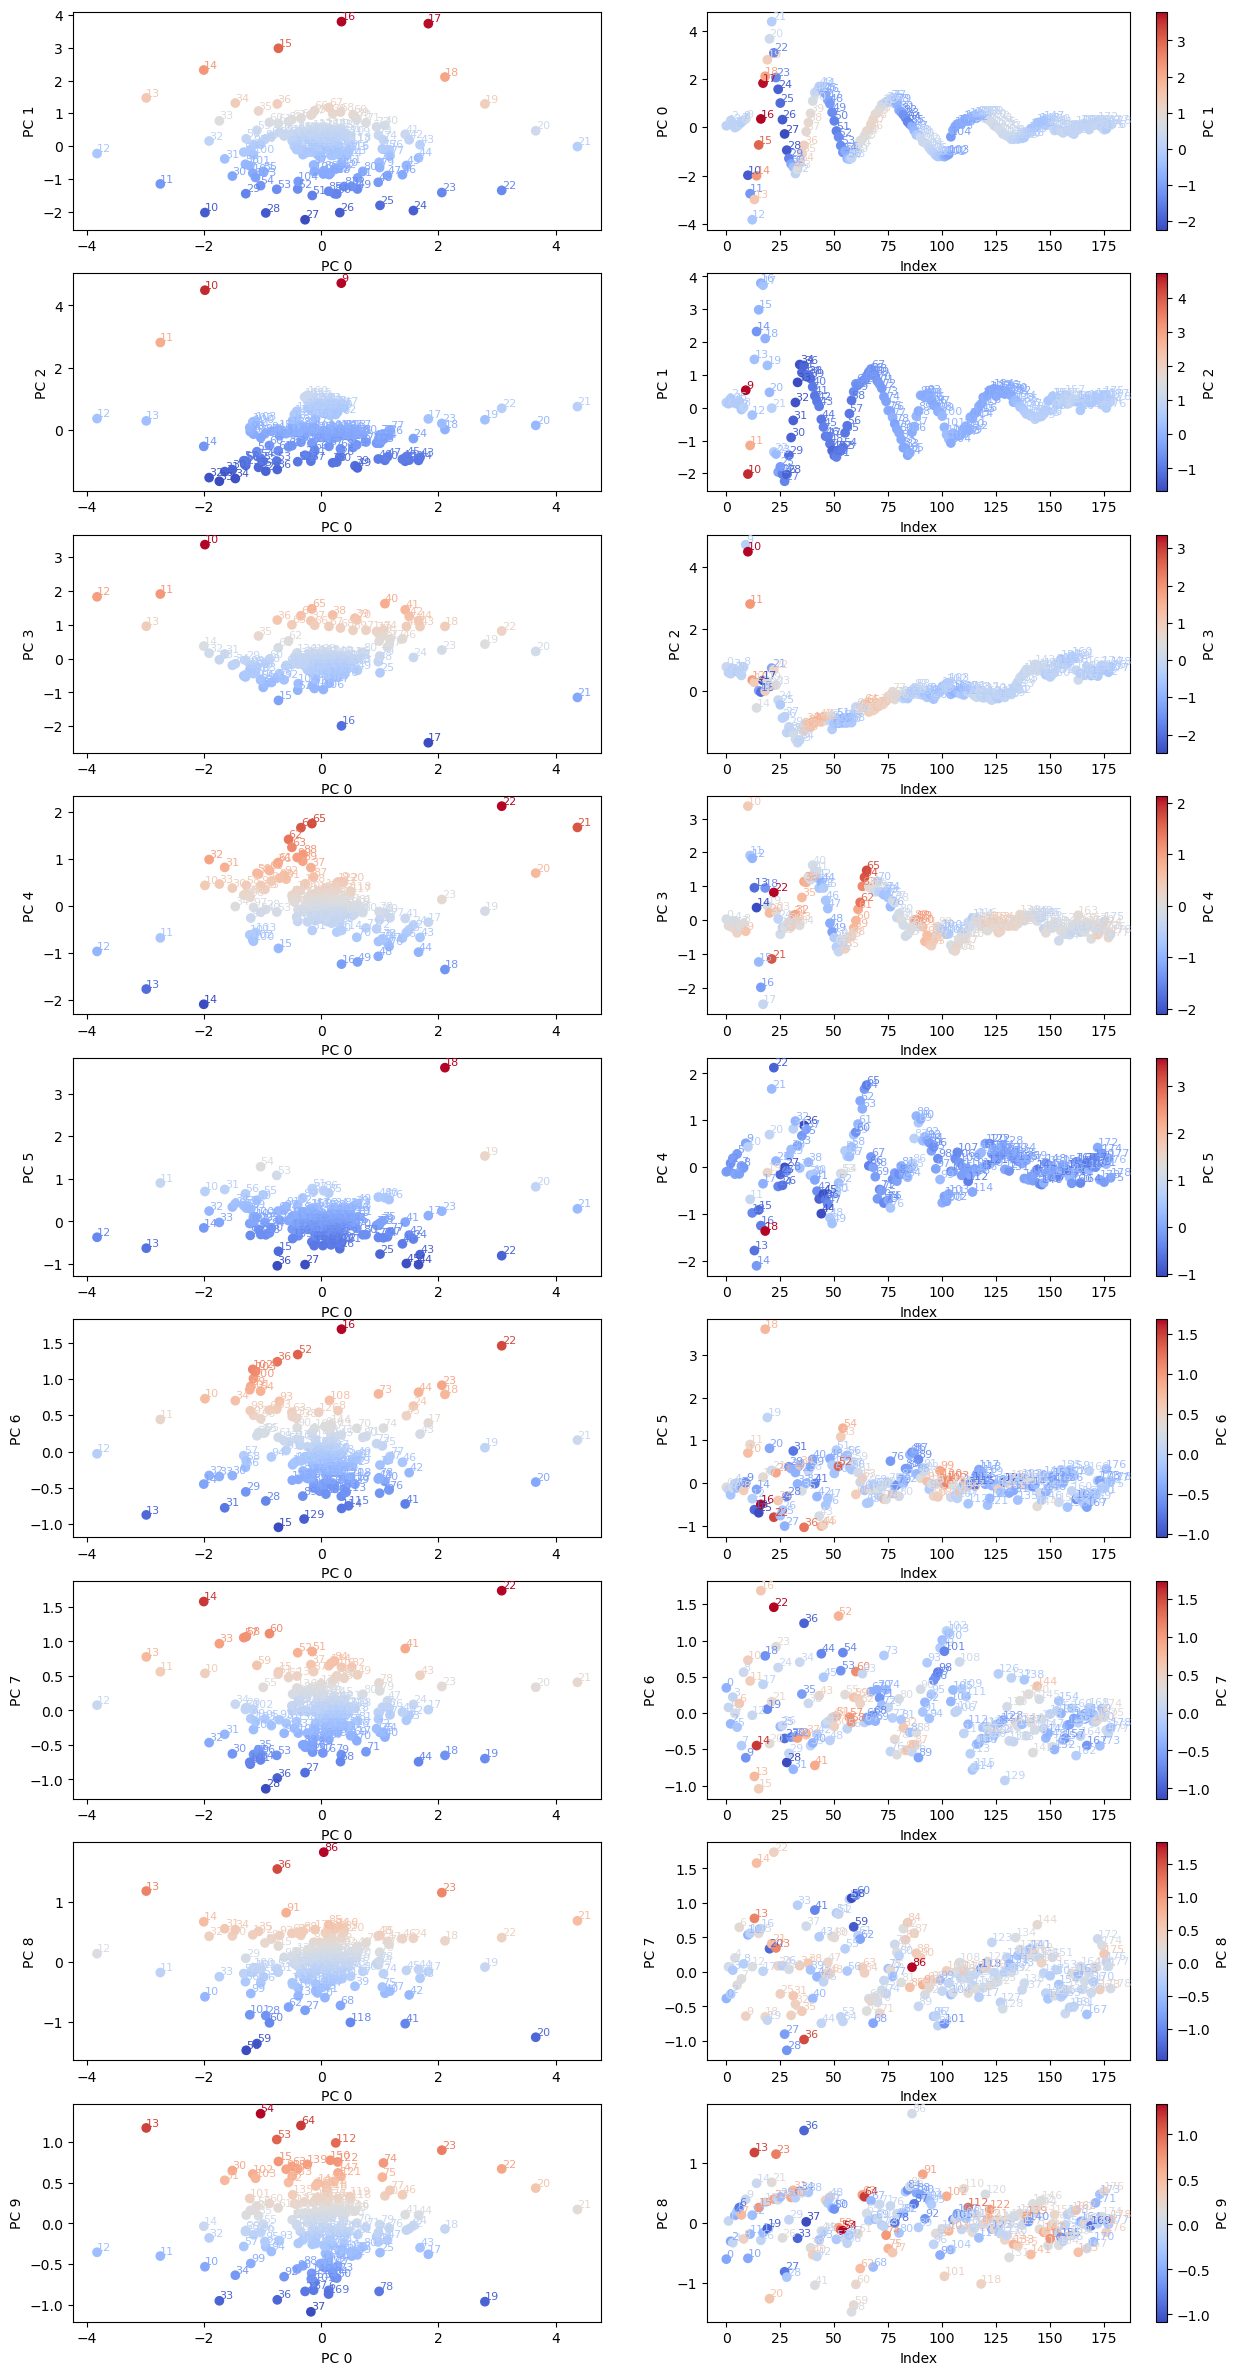

In [6]:
# let's take a look at our embeddings
embed = new_model.emb[1].detach().cpu().numpy()
PlottingContext.plot_embedding(embed, num_components=10)

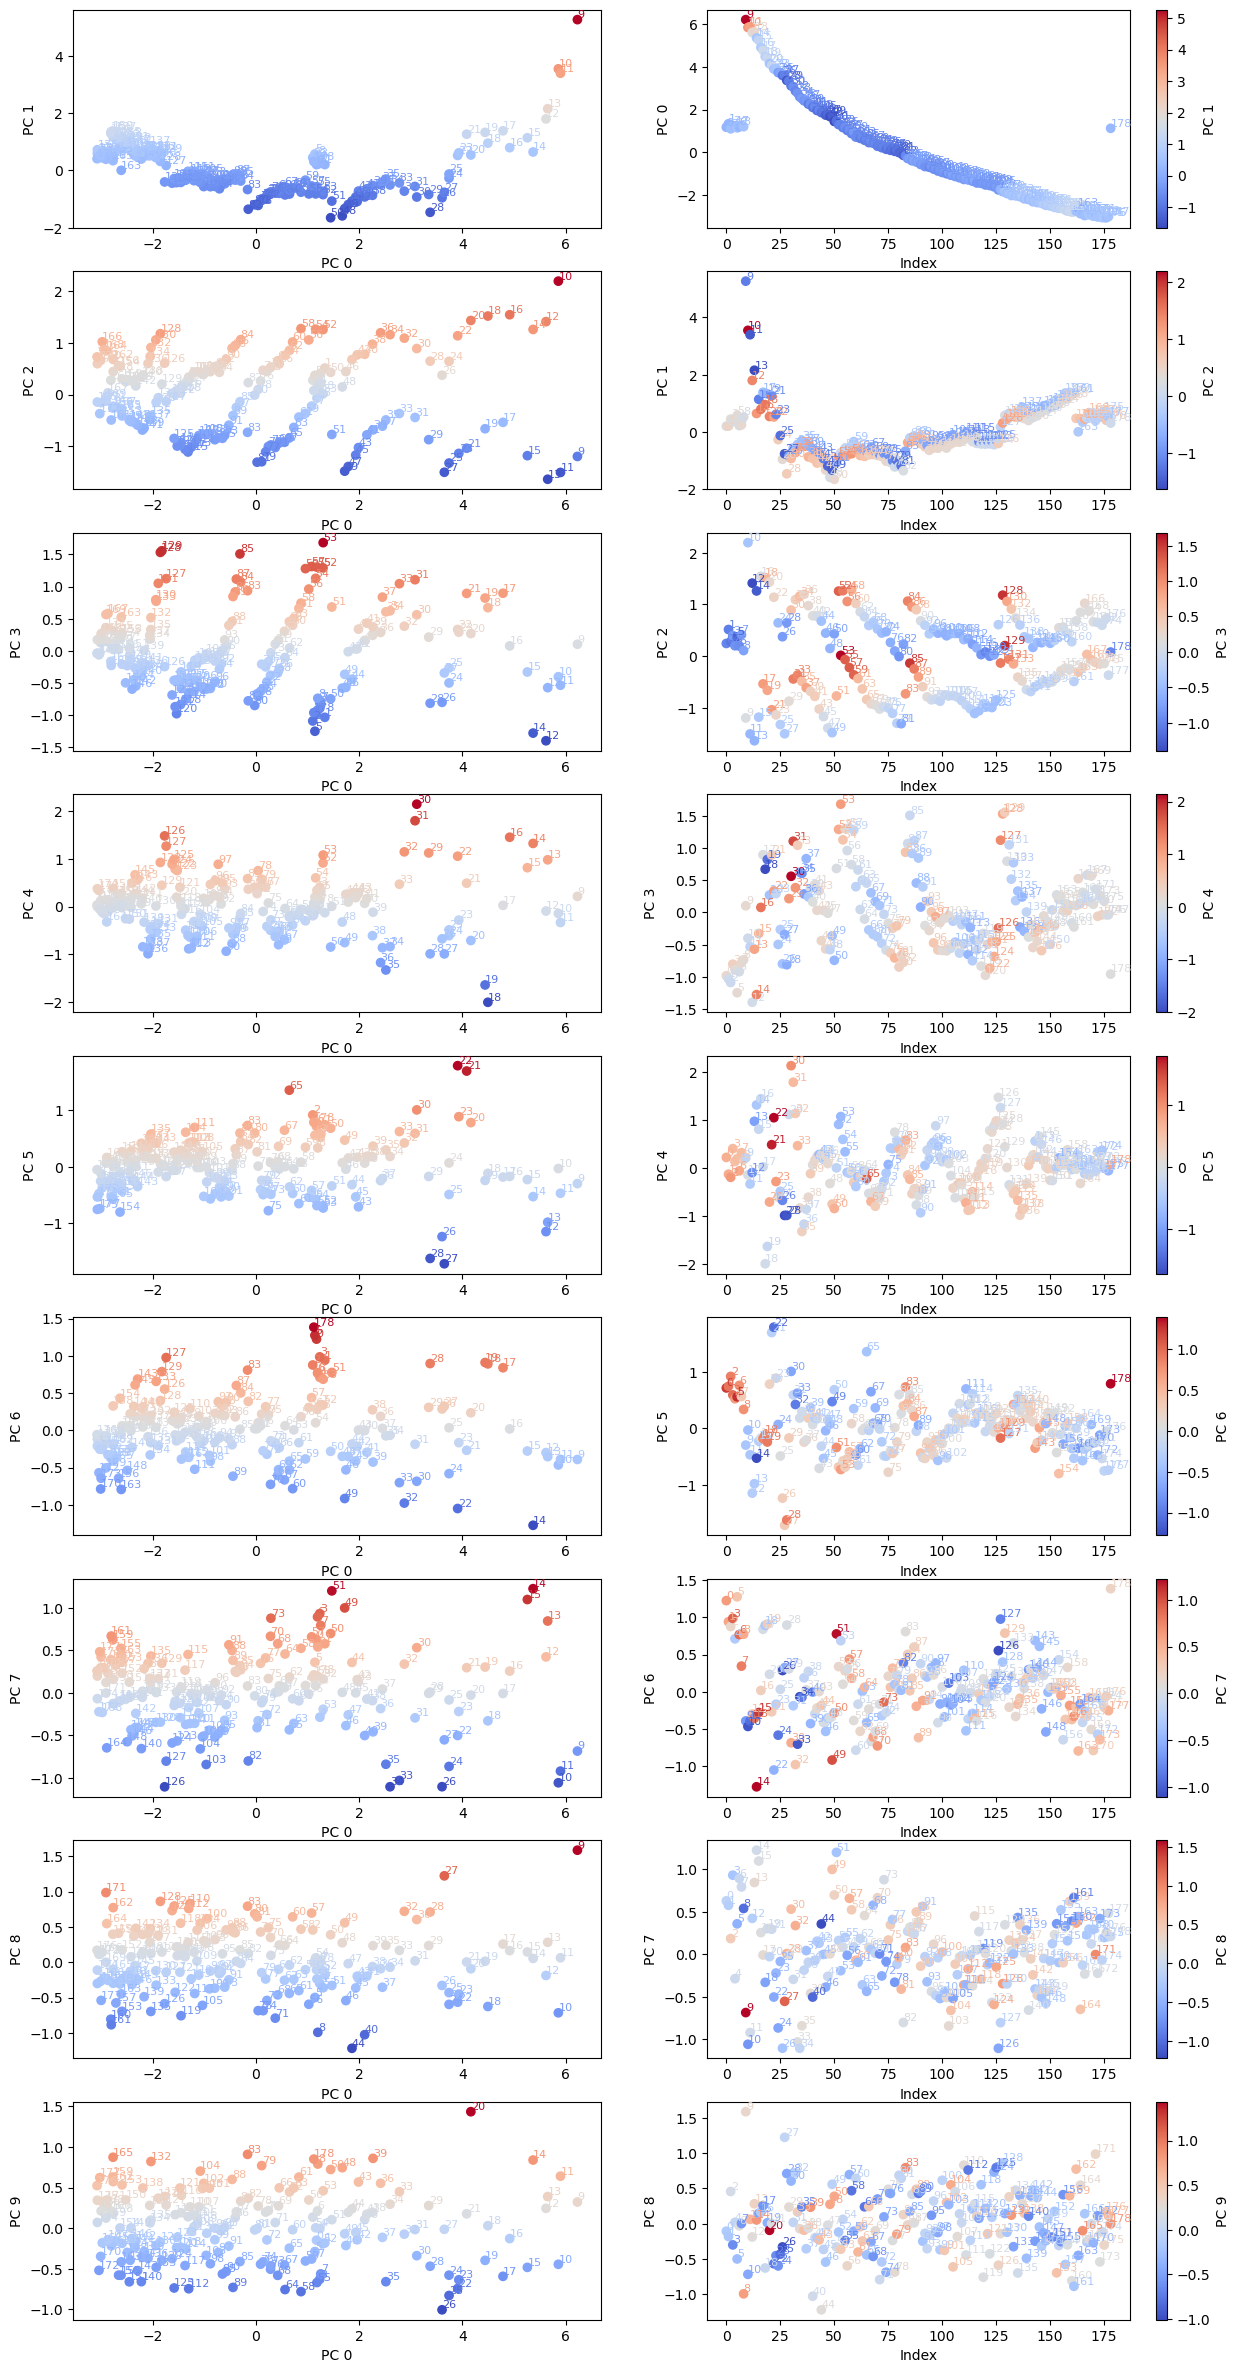

In [ ]:
# let's take a look at our embeddings
embed = new_model.emb[1].detach().cpu().numpy()
PlottingContext.plot_embedding(embed, num_components=10)

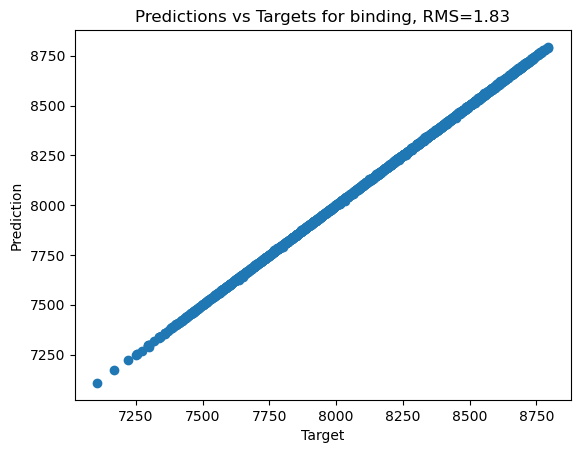

RMS: 1.83


In [ ]:
# visualize the predictions
PlottingContext.plot_predictions(data, new_model, "binding", train=True)

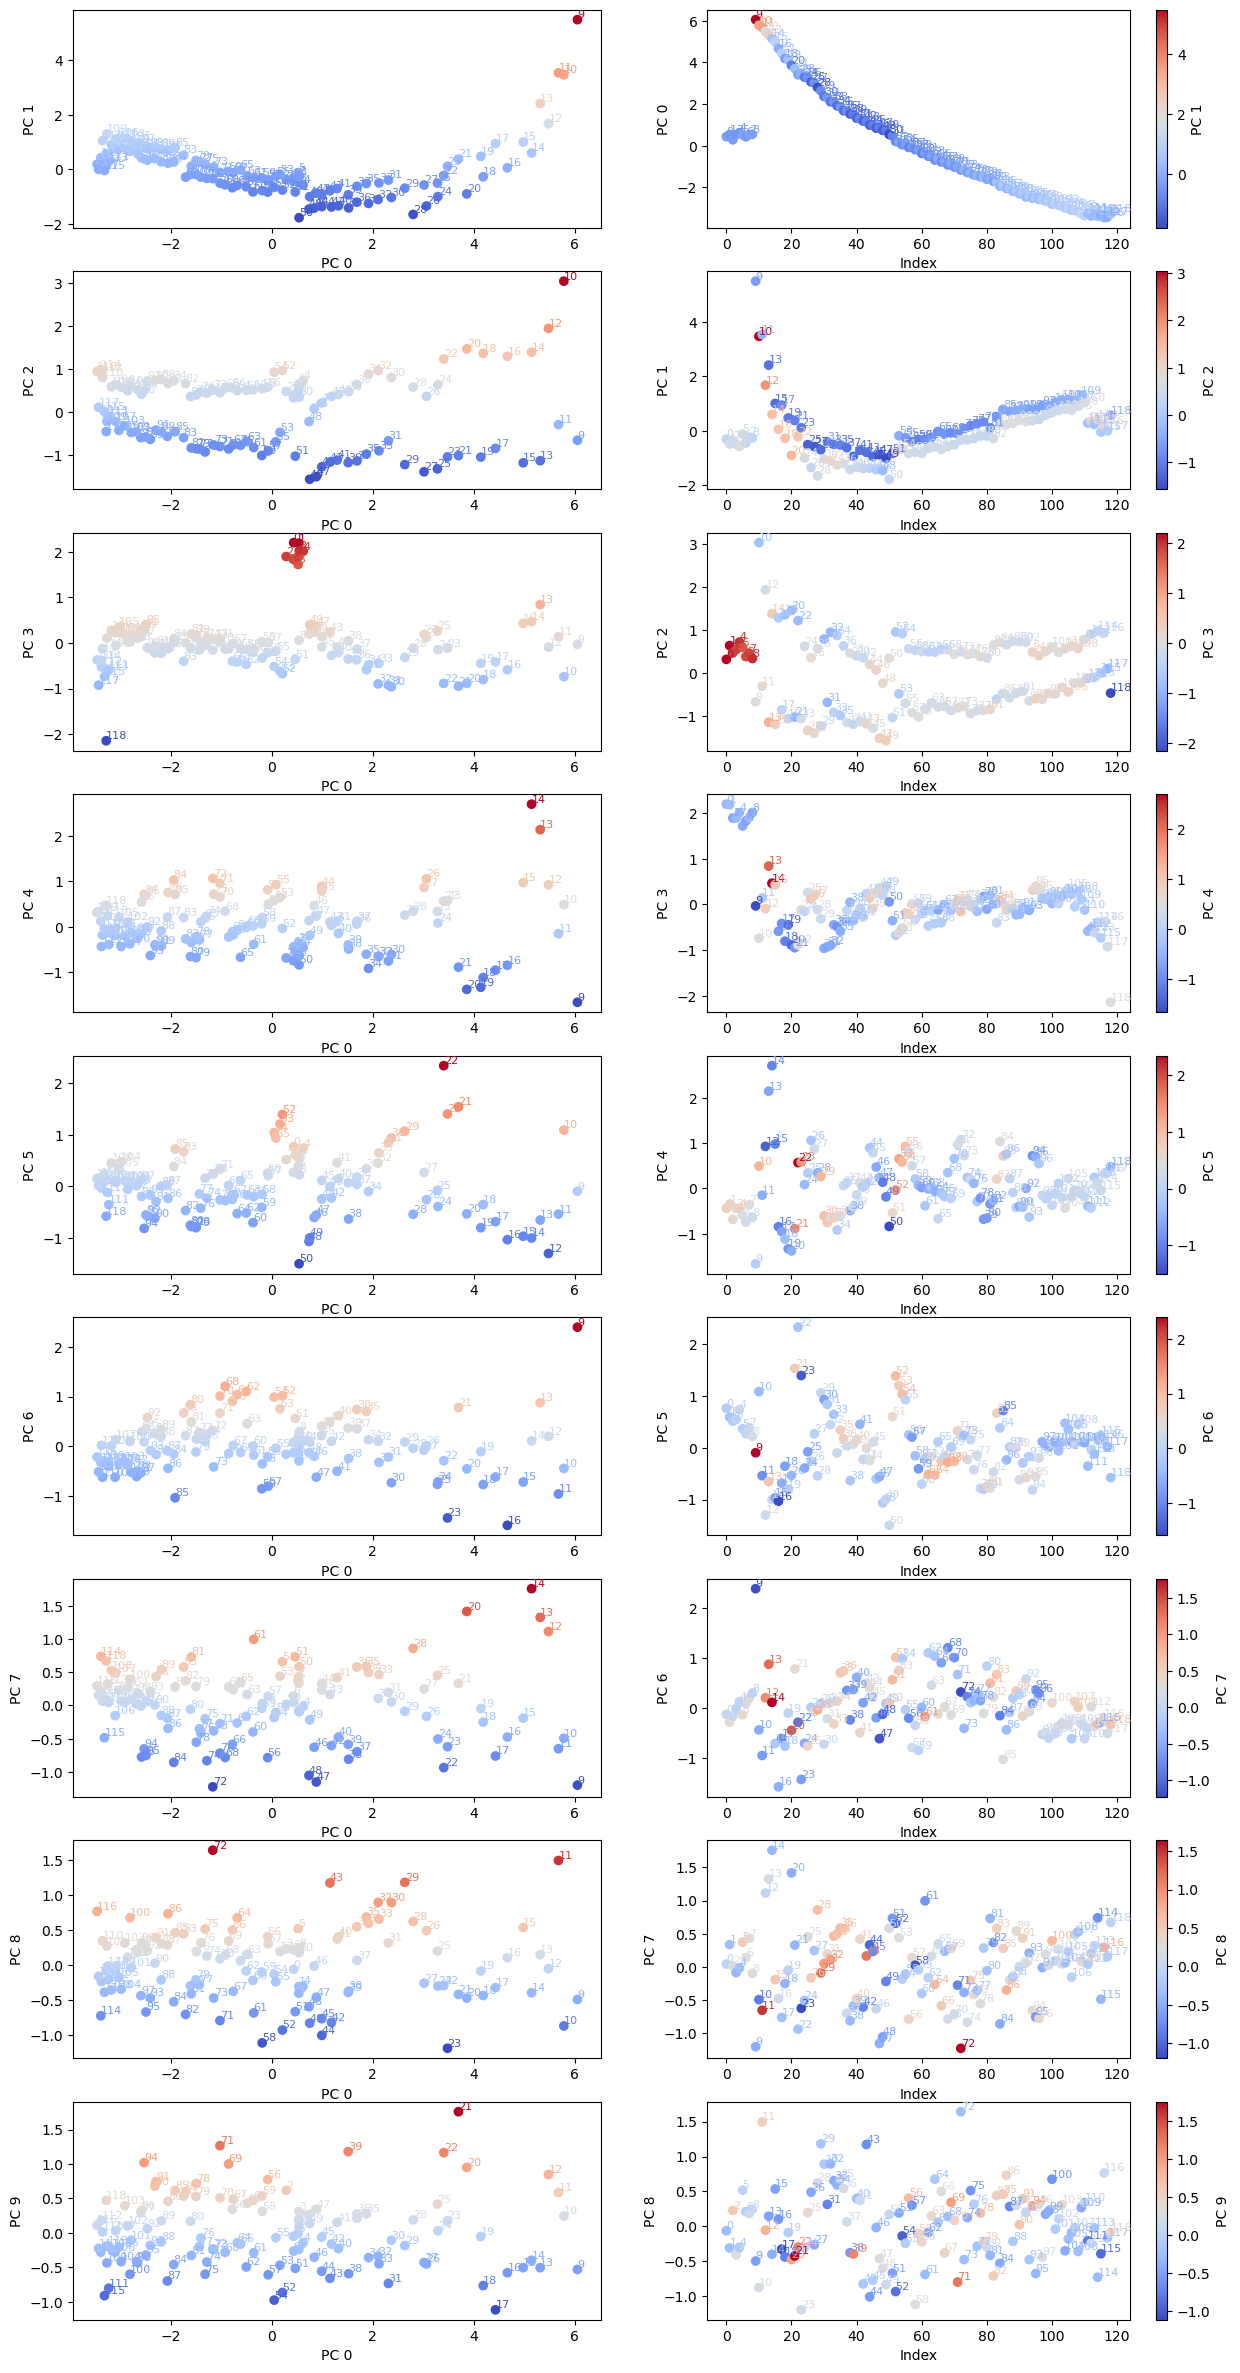

In [ ]:
# let's take a look at our embeddings
embed = new_model.emb[0].detach().cpu().numpy()
PlottingContext.plot_embedding(embed, num_components=10)

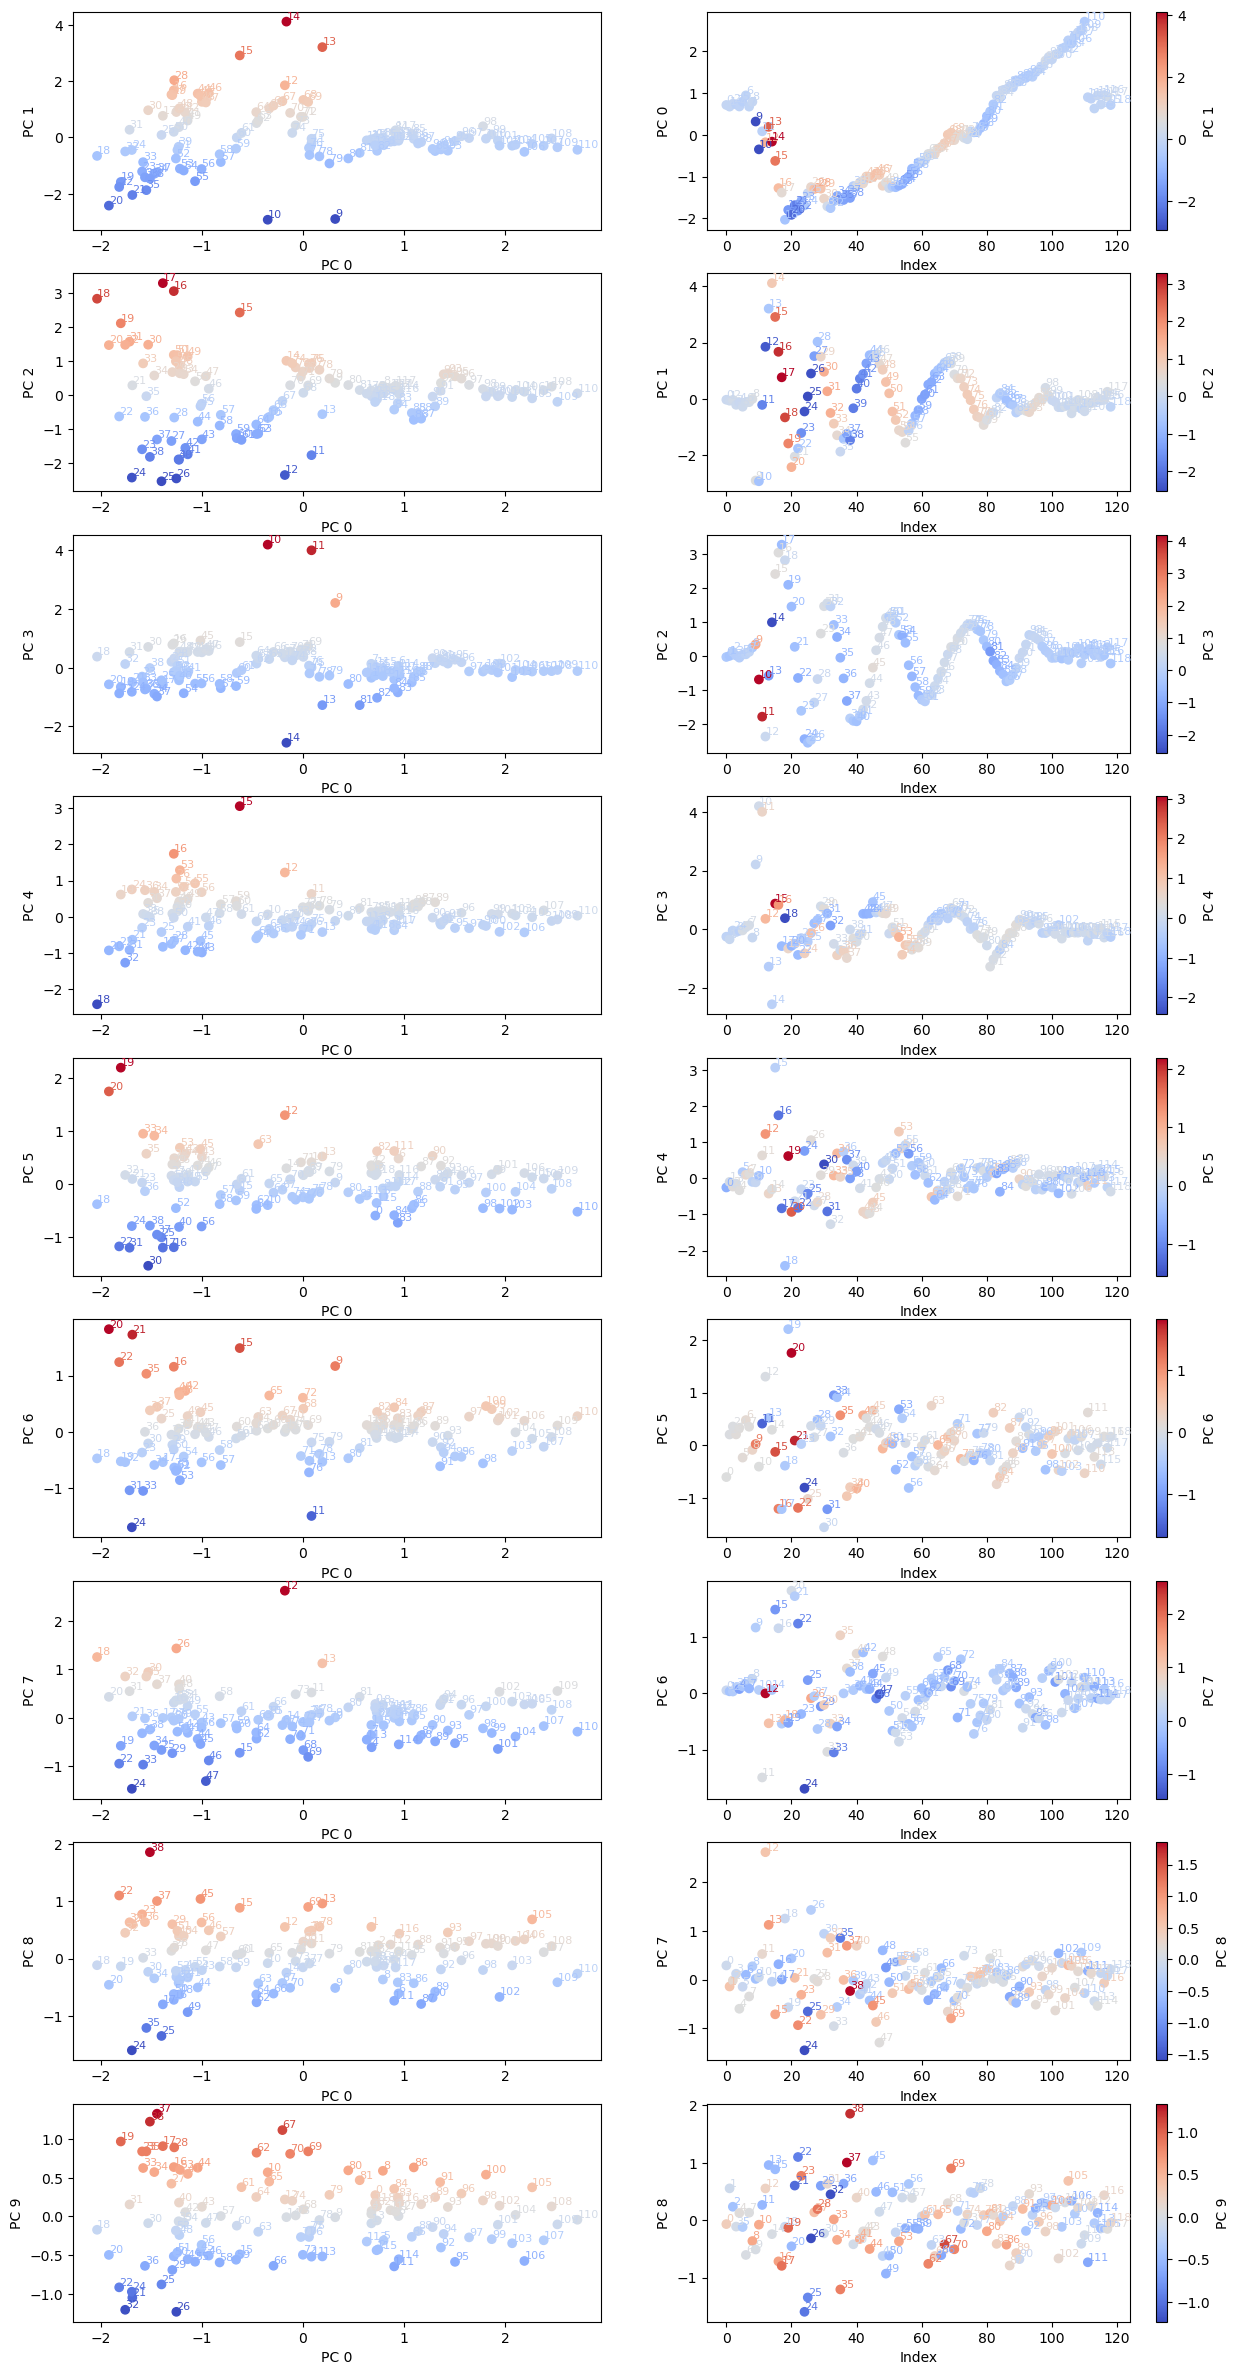

In [ ]:
# let's take a look at our embeddings
embed = new_model.emb[0].detach().cpu().numpy()
PlottingContext.plot_embedding(embed, num_components=10)

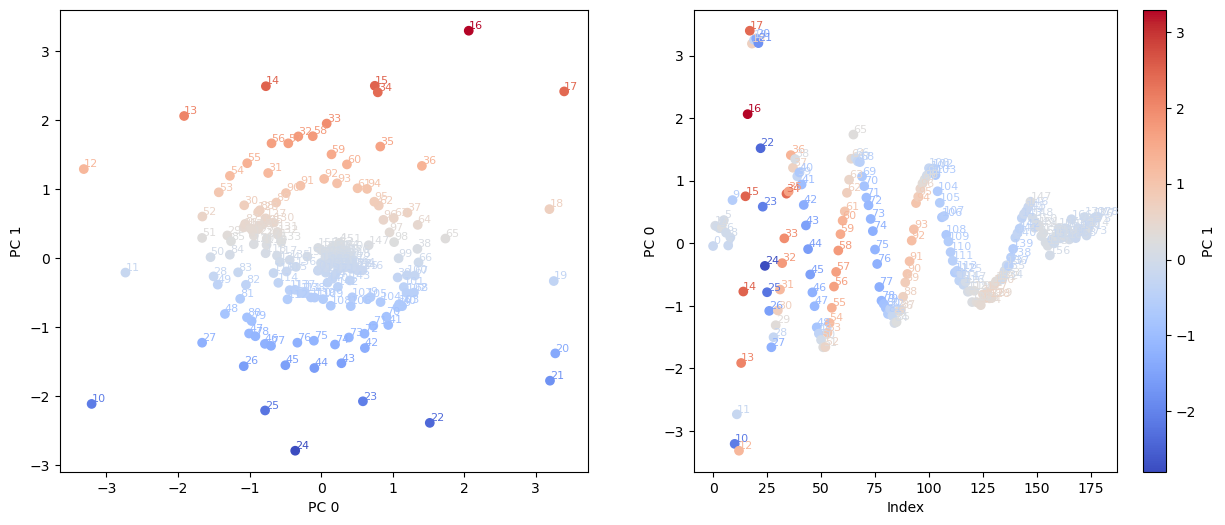

In [ ]:
# let's take a look at our embeddings
embed = new_model.emb[1].detach().cpu().numpy()
PlottingContext.plot_embedding(embed, num_components=3)

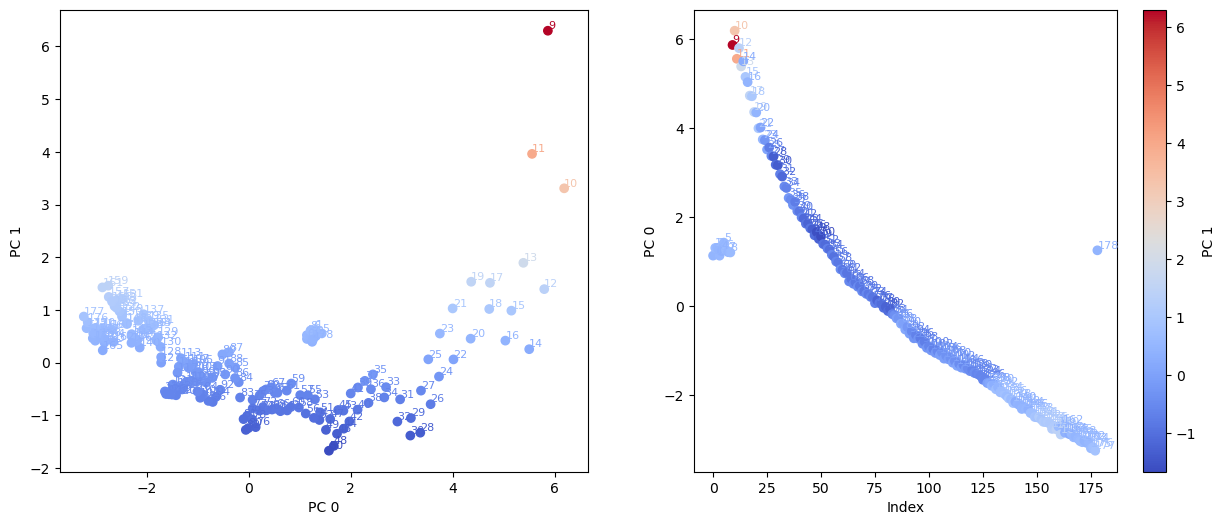

In [ ]:
# let's take a look at our embeddings
embed = new_model.emb[1].detach().cpu().numpy()
PlottingContext.plot_embedding(embed, num_components=2)

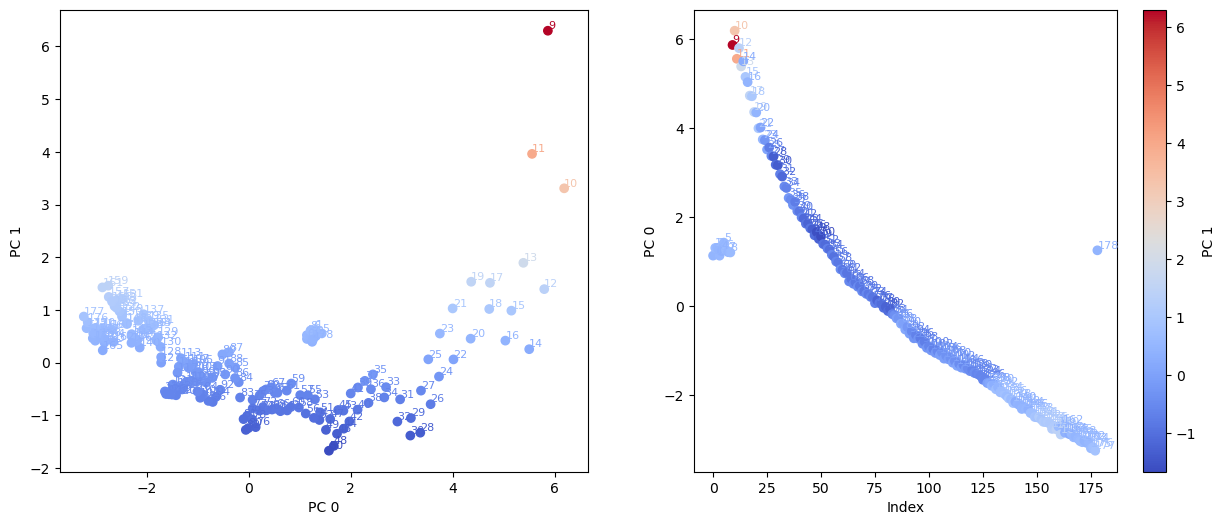

In [ ]:
# let's take a look at our embeddings
embed = new_model.emb[1].detach().cpu().numpy()
PlottingContext.plot_embedding(embed, num_components=2)

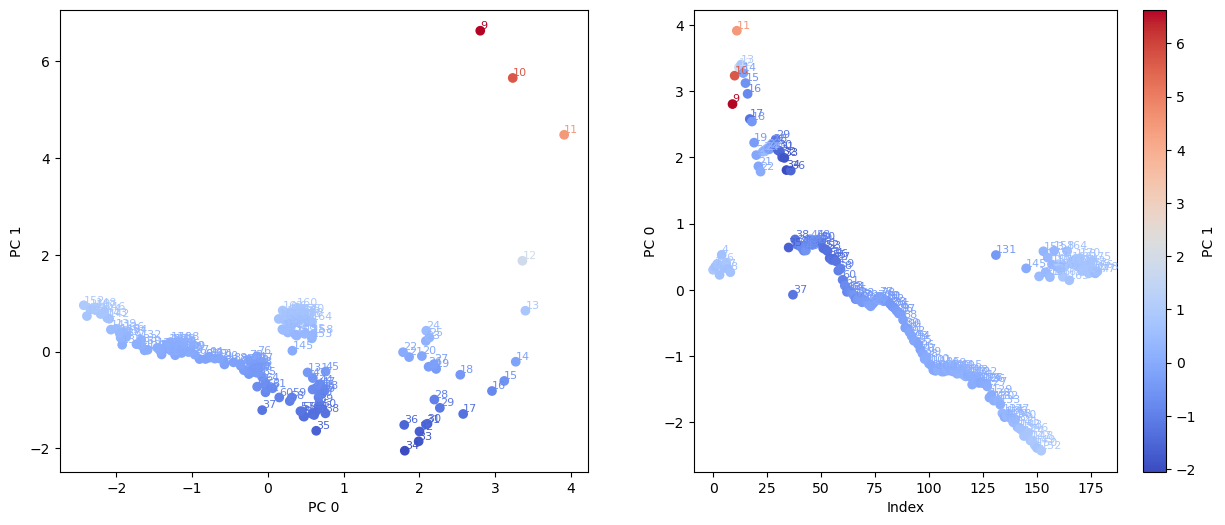

In [ ]:
# let's take a look at our embeddings
embed = new_model.emb[1].detach().cpu().numpy()
PlottingContext.plot_embedding(embed, num_components=2)